# Stats analysis

## Setup

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import seaborn as sns

from scipy import stats
import math

from collections import Counter

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import pingouin as pg



In [4]:
experiments = pd.read_csv('../evaluation/resources/2020/all_experiments.csv')  
experiments = experiments.fillna('-')
experiments.subgroup = experiments.subgroup.apply(lambda row: 'none' if row == 'ignore' else row)
experiments.gr = experiments.apply(lambda df: '_'.join([df.group, df.subgroup]) if (df.group != '-' and df.subgroup != '-') else df.group, axis = 1)
experiments['gr'] = experiments.apply(lambda df: '_'.join([df.group, df.subgroup]),axis = 1)
experiments = experiments.drop('util', axis=1)
experiments = experiments.rename({'difference':'difference_h','disparity':'disparity_h','relevance':'relevance_h','difference_ind':'difference_i','disparity_ind':'disparity_i','relevance_ind':'relevance_i'},axis=1)

experiments.ranker = experiments.ranker.apply(lambda row: f'{row}e' if row == 'rfr' else row)
experiments.ranker.value_counts()

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


ac                  55680
rfre                 9280
lambdamart           2280
relevance_ranker       40
Name: ranker, dtype: int64

### methods

In [5]:
def omega_squared(df_effect, ms_effect, ms_error, ss_total):
    wsq = (df_effect * (ms_effect - ms_error)) / (ss_total - ms_error)
    return wsq
    

In [6]:
def omega_squared_partial(df_effect, ms_effect, ms_error, N):
    wsqp = (df_effect *(ms_effect-ms_error))/(df_effect*ms_effect + (N-df_effect)*ms_error)
    return wsqp

In [7]:
def cohens_d(m1, m2, ms_error):
    return abs(m1 - m2) / math.sqrt(ms_error)

In [8]:
def ci(dfe, V, num_observations):
    t = stats.t.ppf(1-0.025, dfe)
    return t*math.sqrt(V/num_observations)

In [9]:
def print_omegasq(anova, factor, N, roundd):
    ms_effect = anova.mean_sq.loc[f'C({factor})']
    ms_error = anova.mean_sq.loc['Residual']
    df_effect = anova.df.loc[f'C({factor})']
    ss_total = anova.sum_sq.sum()
    
    
    print(f"omega-squared\tomega-squared partial")
    print(f"{round(omega_squared(df_effect, ms_effect, ms_error, ss_total),roundd)}\t\t\t{round(omega_squared_partial(df_effect, ms_effect, ms_error, N),roundd)}")
    print()

In [10]:
def plot_levels_anova(anova, data, feature, dv,plotthese=['difference','disparity','relevance'], groupby_order=None):
    plt.rcParams["axes.labelsize"] = 13
    
    ms_error = anova.mean_sq.loc['Residual']
    dfe = anova.df.loc['Residual']
    datasorted = data.sort_values(by=feature)
    if groupby_order:
        
        # Create a dummy df with the required list and the col name to sort on
        dummy = pd.Series(groupby_order, name = feature).to_frame()

        # Use left merge on the dummy to return a sorted df
        datasorted = pd.merge(dummy, datasorted, on = feature, how = 'left')
        
        # datasorted = datasorted[sort_values_like]
    groups = datasorted.groupby(feature)
    means = groups[dv].mean()
    cis = [ci(dfe, ms_error,20)]    *len(groups)

    
    fig, axs = plt.subplots(1,len(plotthese),figsize=(20,10))

    if '_i' in dv:
        addition = '_i'
    elif '_h' in dv:
        addition = '_h'
    elif '_e' in dv:
        addition = '_e'
    else:
        raise ValueError
    

    if len(plotthese) == 1:
        _ = sns.barplot(x=feature, y=f'difference{addition}',ci=None, yerr=cis, data=datasorted,ax=axs)
        _ = axs.bar_label(axs.containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
    
    else:
        _ = sns.barplot(x=feature, y=f'difference{addition}',ci=None, yerr=cis, data=datasorted,ax=axs[0])
        _ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
        if 'disparity' in plotthese:
            _ = sns.barplot(x=feature, y=f'disparity{addition}', ci=None, data=datasorted, ax=axs[1])
            _ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
        if 'relevance' in plotthese:
            _ = sns.barplot(x=feature, y=f'relevance{addition}', ci=None, data=datasorted, ax=axs[2])
            _ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)


In [105]:
def plot_levels_t(V, df, data, feature, dv,plotthese=['difference','disparity','relevance']):
    plt.rcParams["axes.labelsize"] = 13
    
    
    datasorted = data.sort_values(by=feature)
    
    
    
    cis = [ci(df, V,len(datasorted))]*2
 
    
    fig, axs = plt.subplots(1,len(plotthese),figsize=(20,10))

    if '_i' in dv:
        addition = '_i'
    elif '_h' in dv:
        addition = '_h'
    elif '_e' in dv:
        addition = '_e'
    else:
        raise ValueError
    
    if len(plotthese) == 1:
        _ = sns.barplot(x=feature, y=f'difference{addition}',ci=None, yerr=cis, data=datasorted,ax=axs)
        _ = axs.bar_label(axs.containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
    
    else:
        _ = sns.barplot(x=feature, y=f'difference{addition}',ci=None, yerr=cis, data=datasorted,ax=axs[0])
        _ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
    if 'disparity' in plotthese:
        _ = sns.barplot(x=feature, y=f'disparity{addition}', ci=None, data=datasorted, ax=axs[1])
        _ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
    if 'relevance' in plotthese:
        _ = sns.barplot(x=feature, y=f'relevance{addition}', ci=None, data=datasorted, ax=axs[2])
        _ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)


In [12]:
def sample_mean(a,b):
    return (a-b).mean()

In [13]:
def bigV(a,b):
    sm = sample_mean(a,b)
    return (((a-b) - sm)**2).sum()/(len(a) - 1)

In [96]:
def effect_size_t_test(a,b,roundd=2):
    differences = a - b
    sm = sample_mean(a,b)
    V = bigV(a,b)
    return round(abs(sm) / math.sqrt(V),roundd)

# Statistical analysis LM

## Select LambdaMart data

In [14]:
lambdata = experiments[experiments.ranker == 'lambdamart']
lambdata = lambdata.reset_index(drop=True)
lambdata

,difference_h,disparity_h,relevance_h,difference_i,disparity_i,relevance_i,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.21168,1.96463,1.43316,1.68645,1.32943,0.04198,3462,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
1,1.07183,2.17346,0.99640,1.90473,1.32943,0.10384,8940,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
2,0.69834,3.45495,1.98301,1.53864,1.31771,0.06697,10795,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
3,0.80910,1.65976,0.75591,1.46067,1.32943,0.01519,12073,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
4,0.24675,2.39058,1.93819,2.07945,1.33332,0.01797,12096,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,0.71886,3.09551,1.74605,1.76113,1.33327,0.00656,64062,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
2276,0.01131,2.15078,1.99585,0.52595,1.08236,0.66969,66637,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
2277,0.01039,1.77589,1.73610,0.59773,1.08333,0.63429,67404,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
2278,0.52623,1.54197,0.97068,1.75083,1.31769,0.17458,70673,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-


## Relevance

### Augmentation

In [15]:
augdata = lambdata.query('val_metric == "ndcg" and feature_method == "-"')

##### ANOVA

In [16]:
formula = "difference_h ~ C(augmentation) + C(qid)"
lm = ols(formula, augdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,0.07726,0.03863,0.32185,0.72677
C(qid),19.00000,24.75159,1.30272,10.85339,0.00000
Residual,38.00000,4.56108,0.12003,NaN,NaN


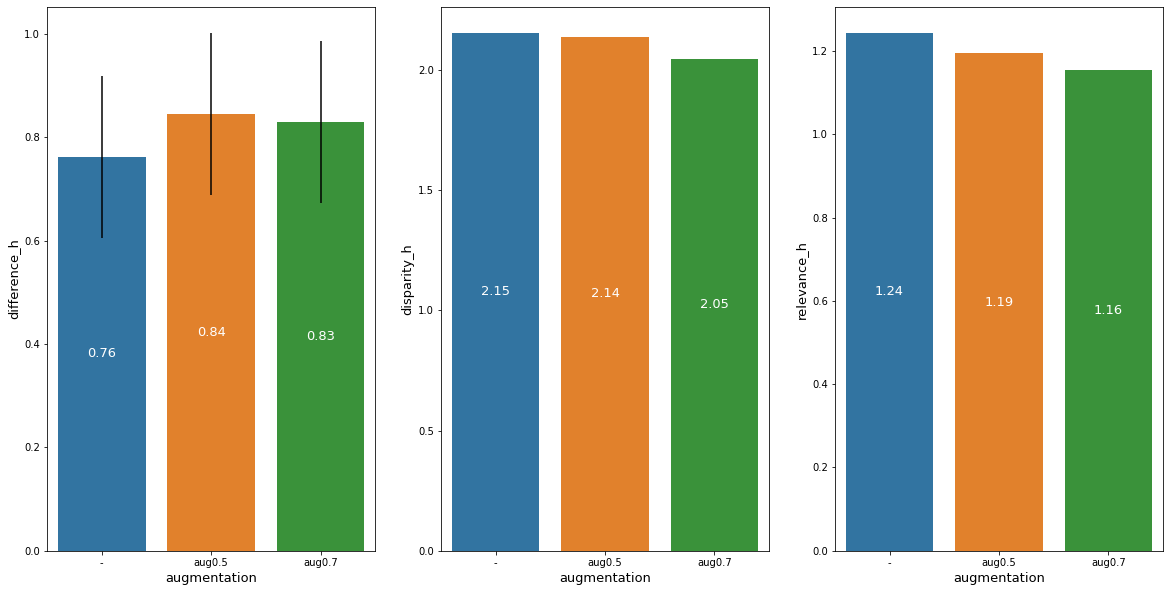

In [17]:
plot_levels_anova(anova,augdata,'augmentation','difference_h')

In [21]:
formula = "difference_i ~ C(augmentation) + C(qid)"
lm = ols(formula, augdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,0.64800,0.32400,2.22811,0.12162
C(qid),19.00000,6.46879,0.34046,2.34131,0.01261
Residual,38.00000,5.52578,0.14542,NaN,NaN


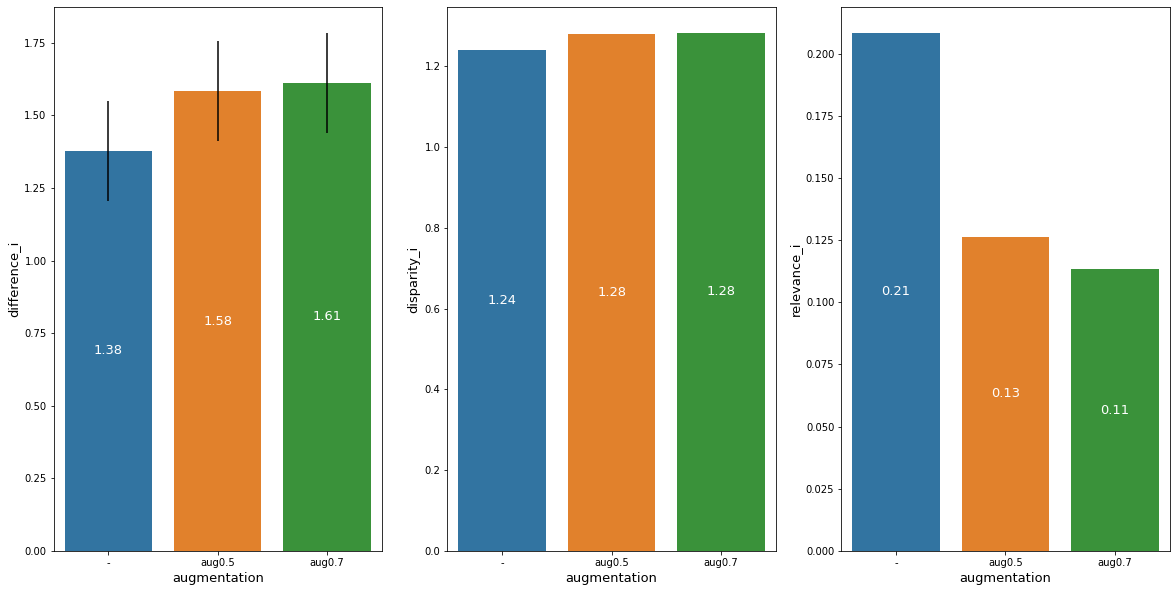

In [22]:
plot_levels_anova(anova,augdata,'augmentation','difference_i')

### Feature selection

In [23]:
featdata = lambdata.query('val_metric == "ndcg" and augmentation == "-"')

In [24]:
featdata['mrgd'] = featdata.apply(lambda row: '_'.join([row.feature_method, row.num_features, row.balancing_factor]),axis=1)

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


##### ANOVA

In [25]:
formula = "difference ~ C(feature_method) + C(qid)"
lm = ols(formula, featdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

PatsyError: Error evaluating factor: NameError: name 'difference' is not defined
    difference ~ C(feature_method) + C(qid)
    ^^^^^^^^^^

In [26]:
formula = "difference_ind ~ C(feature_method) + C(qid)"
lm = ols(formula, featdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

PatsyError: Error evaluating factor: NameError: name 'difference_ind' is not defined
    difference_ind ~ C(feature_method) + C(qid)
    ^^^^^^^^^^^^^^

### Opt metric

In [27]:
mdata = lambdata.query('feature_method == "-" and augmentation == "-"')

In [28]:
a = mdata.query('val_metric == "ndcg"').difference.reset_index(drop=True)

AttributeError: 'DataFrame' object has no attribute 'difference'

In [29]:
b = mdata.query('val_metric == "err"').difference.reset_index(drop=True)

AttributeError: 'DataFrame' object has no attribute 'difference'

In [30]:
pg.ttest(a, b, paired=True)

NameError: name 'a' is not defined

In [31]:
plot_levels_t(bigV(a,b),19,mdata,'val_metric','difference')

NameError: name 'a' is not defined

In [32]:
a = mdata.query('val_metric == "ndcg"').difference_ind.reset_index(drop=True)

AttributeError: 'DataFrame' object has no attribute 'difference_ind'

In [33]:
b = mdata.query('val_metric == "err"').difference_ind.reset_index(drop=True)

AttributeError: 'DataFrame' object has no attribute 'difference_ind'

In [34]:
pg.ttest(a, b, paired=True)

NameError: name 'a' is not defined

In [35]:
plot_levels_t(bigV(a,b),19,mdata,'val_metric','difference_ind')

NameError: name 'a' is not defined

## LM post-processing

In [36]:
experiments

,difference_h,disparity_h,relevance_h,difference_i,disparity_i,relevance_i,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,3462,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,8940,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,10795,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,12073,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,12096,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,64062,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,66637,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,67404,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,70673,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-


In [37]:
experiments.ranker.value_counts()

ac                  55680
rfre                 9280
lambdamart           2280
relevance_ranker       40
Name: ranker, dtype: int64

In [38]:
ppdata = experiments.query('((ranker == "lambdamart" and source == "-" and augmentation == "-" and feature_method == "-" and val_metric == "ndcg") or (ranker == "rfre" and source == "lambdamart_noaug_ndcg_nofeat" and group=="author" and subgroup=="none") or (ranker == "ac" and source == "lambdamart_noaug_ndcg_nofeat" and hfunc == "linear" and gr == "author_none" and theta == 9))')
ppdata = ppdata.reset_index(drop=True)
ppdata = ppdata[['difference_i','disparity_i','relevance_i','difference_h','disparity_h','relevance_h','qid','source','theta','hfunc','ranker','gr']]
ppdata = ppdata.rename({'gr':'group'},axis=1)
ppdata['group'] = ppdata.group.apply(lambda row: row.replace('_-',''))
# ppdata['ranker'] = ppdata.apply(lambda row: '_'.join([row.ranker, str(row.theta)]).replace('_-',''),axis = 1)

ppdata.ranker = ppdata.ranker.apply(lambda row: 'base' if row == 'lambdamart' else row)

ppdata.head()

,difference_i,disparity_i,relevance_i,difference_h,disparity_h,relevance_h,qid,source,theta,hfunc,ranker,group
0,0.42183,0.13194,0.07555,0.12558,1.81614,1.40197,3462,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
1,0.70721,0.37100,0.22339,0.76783,1.81553,0.96944,8940,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
2,0.43046,0.20536,0.06488,0.22669,1.85391,1.41831,10795,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
3,0.09658,0.10259,0.08381,0.06271,0.91117,0.75481,12073,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
4,0.75770,0.24510,0.13473,0.26299,1.39140,1.43049,12096,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none


In [39]:
ppdata.ranker.value_counts()

ac      20
base    20
rfre    20
Name: ranker, dtype: int64

In [40]:
with pd.option_context('precision', 3):
   print( ppdata.drop(['source','theta','hfunc','group'],axis=1).groupby('ranker').mean().round(3)[['difference_i','disparity_i','relevance_i','difference_h','disparity_h','relevance_h']].reset_index())

  ranker  difference_i  disparity_i  relevance_i  difference_h  disparity_h  relevance_h
0     ac       0.45900      0.23300      0.16500       0.40900      1.61500      1.15000
1   base       1.37800      1.23900      0.20800       0.76200      2.15400      1.24300
2   rfre       0.55400      0.30100      0.15100       0.49500      1.65600      1.12700


### EEL

#### ANOVA

In [41]:
formula = "difference_h ~ C(ranker) + C(qid)"
lm = ols(formula, ppdata).fit()
lm.summary()
anova = anova_lm(lm)
with pd.option_context('precision', 2):
    print(anova.round(2))

                df   sum_sq  mean_sq        F  PR(>F)
C(ranker)  2.00000  1.35000  0.68000  9.56000 0.00000
C(qid)    19.00000 18.16000  0.96000 13.49000 0.00000
Residual  38.00000  2.69000  0.07000      NaN     NaN


In [42]:
print_omegasq(anova,'ranker',20,2)
print_omegasq(anova,'qid',3,2)

omega-squared	omega-squared partial
0.05			0.46

omega-squared	omega-squared partial
0.76			0.99



#### Visualize

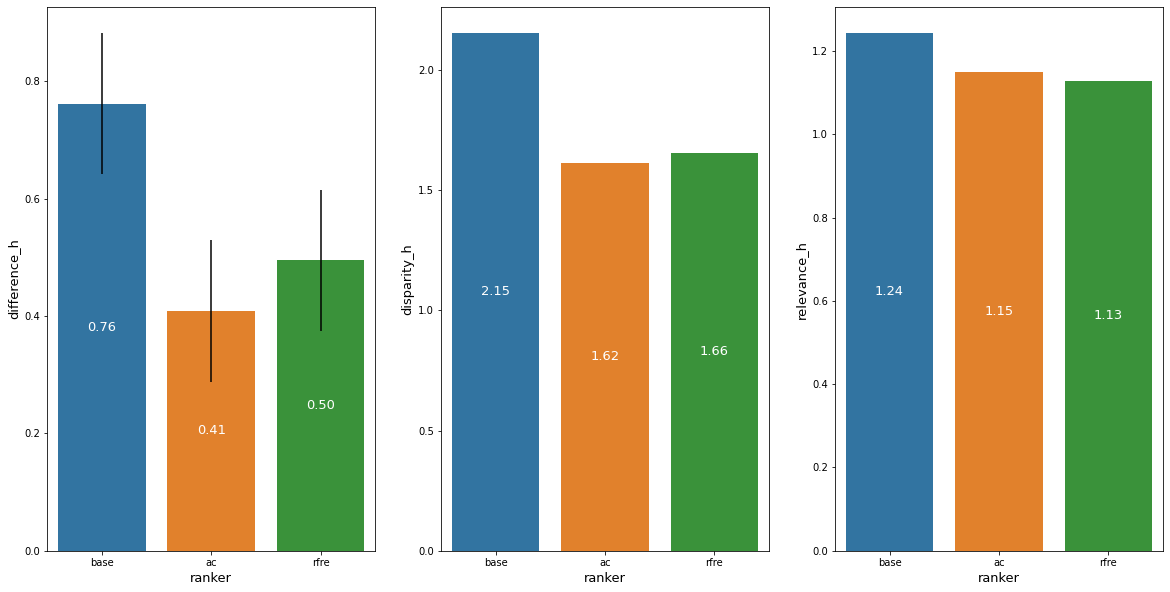

In [43]:
plot_levels_anova(anova, ppdata,'ranker','difference_h', groupby_order=['base','ac','rfre'])

#### Tukey

In [44]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ppdata['difference_h'], groups=ppdata['ranker'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    ac   base    0.353 0.1642 -0.1073 0.8133  False
    ac   rfre   0.0862 0.8944 -0.3741 0.5464  False
  base   rfre  -0.2668 0.3503 -0.7271 0.1935  False
---------------------------------------------------


In [45]:
ppdata.groupby('ranker').get_group('base').difference_h.mean()

0.7619148

In [46]:
# augmentation
means = ppdata.groupby('ranker')['difference_h'].mean()
m1 = means['base']
m2 = means['ac']
m3 = means['rfre']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


1.3261765029691692
1.0024648988780485
0.32371160409112065


### ERR

#### ANOVA

In [47]:
ppdata

,difference_i,disparity_i,relevance_i,difference_h,disparity_h,relevance_h,qid,source,theta,hfunc,ranker,group
0,0.42183,0.13194,0.07555,0.12558,1.81614,1.40197,3462,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
1,0.70721,0.37100,0.22339,0.76783,1.81553,0.96944,8940,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
2,0.43046,0.20536,0.06488,0.22669,1.85391,1.41831,10795,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
3,0.09658,0.10259,0.08381,0.06271,0.91117,0.75481,12073,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
4,0.75770,0.24510,0.13473,0.26299,1.39140,1.43049,12096,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
5,0.60931,0.33516,0.25433,0.07149,1.34656,1.10168,12828,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
6,0.47631,0.24595,0.17197,0.62905,1.16671,0.75574,20363,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
7,0.33100,0.16213,0.13605,0.78421,2.33009,1.10838,25869,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
8,0.10329,0.07327,0.03177,0.37060,1.94579,1.13970,27887,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
9,0.70313,0.24170,0.16035,0.61394,1.38861,0.81196,30631,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none


In [48]:
formula = "difference_i ~ C(ranker) + C(qid)"
lm = ols(formula, ppdata).fit()
lm.summary()
anova = anova_lm(lm)

anova

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),2.00000,10.20905,5.10452,53.45454,0.00000
C(qid),19.00000,4.72814,0.24885,2.60595,0.00588
Residual,38.00000,3.62873,0.09549,NaN,NaN


In [49]:
print_omegasq(anova,'ranker',20,2)
print_omegasq(anova,'qid',3,2)

omega-squared	omega-squared partial
0.54			0.84

omega-squared	omega-squared partial
0.16			0.91



#### Visualize

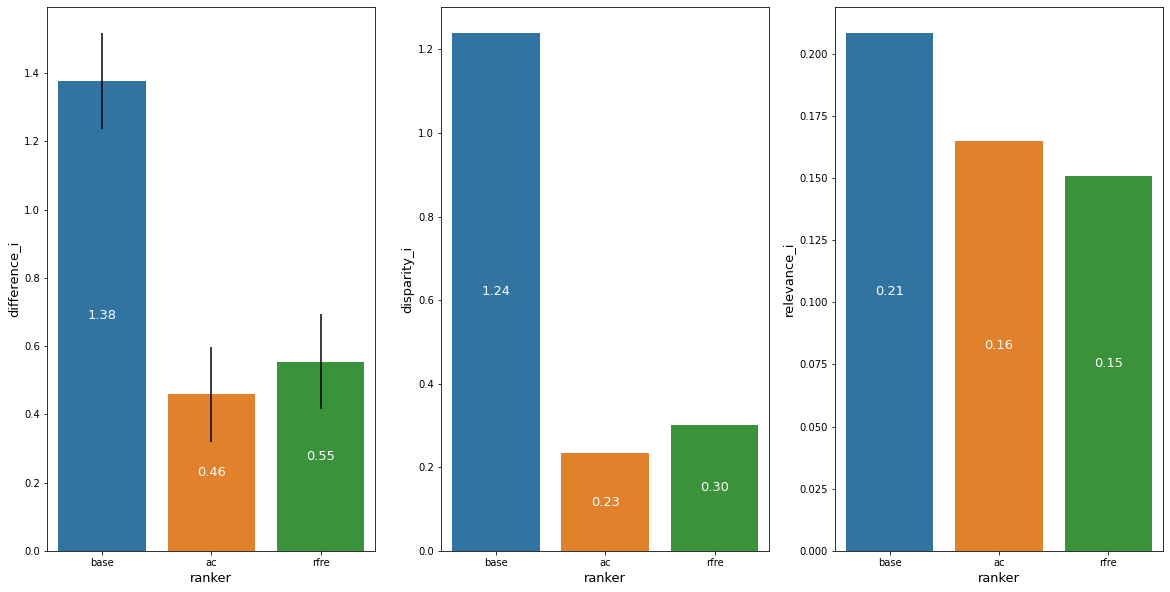

In [50]:
plot_levels_anova(anova, ppdata,'ranker','difference_i',groupby_order=['base','ac','rfre'])

#### Tukey

In [51]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ppdata['difference_i'], groups=ppdata['ranker'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    ac   base   0.9188    0.0  0.6274  1.2101   True
    ac   rfre   0.0953 0.7126 -0.1961  0.3866  False
  base   rfre  -0.8235    0.0 -1.1149 -0.5321   True
----------------------------------------------------


In [52]:
# augmentation
means = ppdata.groupby('ranker')['difference_i'].mean()
m1 = means['base']
m2 = means['ac']
m3 = means['rfre']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


2.973158761601759
2.66489464638334
0.30826411521841884


## LM with RFR

In [53]:
rfrdata = experiments.query('ranker == "rfr" and source == "lambdamart_noaug_ndcg_nofeat"')
rfrdata

,difference_h,disparity_h,relevance_h,difference_i,disparity_i,relevance_i,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr


### EEL

#### ANOVA

In [54]:
formula = "difference_h ~ C(gr) + C(qid)"
lm = ols(formula, rfrdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

ValueError: negative dimensions are not allowed

### ERR

#### ANOVA

In [ ]:
formula = "difference_ind ~ C(gr) + C(qid)"
lm = ols(formula, rfrdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

In [ ]:
print_omegasq(anova,'gr',20,5)
print_omegasq(anova,'qid',4,5)

#### Tukey

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference_ind'], groups=rfrdata['gr'], alpha=0.05)
print(tukey)


## LM with AC

In [ ]:
aclmdata

In [ ]:
aclmdata = experiments.query('ranker == "ac" and source == ')

In [55]:
aclmdata.query('group == "author_none" .groupby(['group','theta','hfunc']).mean().sort_values(by='difference_ind')

SyntaxError: invalid syntax (1654765243.py, line 1)

In [56]:
aclmdata.groupby(['group','theta','hfunc']).mean().sort_values(by='difference')

NameError: name 'aclmdata' is not defined

### EEL

#### ANOVA

In [57]:
formula = "difference ~ C(group) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, aclmdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

NameError: name 'aclmdata' is not defined

In [58]:
print_omegasq(anova,'qid',24,5)

omega-squared	omega-squared partial
0.15775			0.55974



### ERR

#### ANOVA

In [59]:
formula = "difference_ind ~ C(group) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, aclmdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

NameError: name 'aclmdata' is not defined

In [60]:
print_omegasq(anova,'group',120,5)
print_omegasq(anova,'hfunc',160,5)
print_omegasq(anova,'theta',240,5)
print_omegasq(anova,'qid',24,5)

KeyError: 'C(group)'

#### Tukey

In [61]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=aclmdata['difference_ind'], groups=aclmdata['group'], alpha=0.05)
print(tukey)


NameError: name 'aclmdata' is not defined

In [62]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=aclmdata['difference_ind'], groups=aclmdata['theta'], alpha=0.05)
print(tukey)


NameError: name 'aclmdata' is not defined

In [63]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=aclmdata['difference_ind'], groups=aclmdata['hfunc'], alpha=0.05)
print(tukey)


NameError: name 'aclmdata' is not defined

## LM with feature selection

In [64]:
fsdata = experiments.query('ranker == "lambdamart" and source == "-" and augmentation == "-" and val_metric == "ndcg" and ((feature_method != "-" and balancing_factor == "0.5" and num_features == "10") or feature_method == "-")')
fsdata = fsdata.rename({'feature_method':'fsm'},axis=1)
fsdata.fsm = fsdata.fsm.apply(lambda row: 'base' if row == '-' else row)

fsdata.head()

,difference_h,disparity_h,relevance_h,difference_i,disparity_i,relevance_i,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,fsm,num_features,balancing_factor,gr
57600,0.43401,2.00122,1.34029,1.58655,1.31769,0.08606,3462,lambdamart,-,-,-,-,-,-,ndcg,mpt,10,0.5,-_-
57601,0.83030,1.96612,1.01349,0.60187,1.08333,0.63222,8940,lambdamart,-,-,-,-,-,-,ndcg,mpt,10,0.5,-_-
57602,2.17844,2.27540,0.65318,1.67931,1.33327,0.00441,10795,lambdamart,-,-,-,-,-,-,ndcg,mpt,10,0.5,-_-
57603,0.34068,1.09943,0.70995,0.90628,1.06667,0.16100,12073,lambdamart,-,-,-,-,-,-,ndcg,mpt,10,0.5,-_-
57604,0.25737,2.09119,1.78319,2.05040,1.33309,0.03238,12096,lambdamart,-,-,-,-,-,-,ndcg,mpt,10,0.5,-_-


In [65]:
with pd.option_context('precision', 3):
   print( fsdata.drop(['source','theta','hfunc','group'],axis=1).groupby('fsm').mean().round(3)[['difference_i','disparity_i','relevance_i','difference_h','disparity_h','relevance_h']].reset_index())

    fsm  difference_i  disparity_i  relevance_i  difference_h  disparity_h  relevance_h
0  base       1.37800      1.23900      0.20800       0.76200      2.15400      1.24300
1   mpt       1.28600      1.23400      0.25200       0.69600      1.90200      1.14900
2   msd       1.37100      1.25100      0.21800       0.84000      2.28700      1.27000


### ERR

#### ANOVA

In [66]:
formula = "difference_i ~ C(fsm) + C(qid)"
lm = ols(formula, fsdata).fit()
lm.summary()
anova = anova_lm(lm)
anova.round(2)

,df,sum_sq,mean_sq,F,PR(>F)
C(fsm),2.00000,0.11000,0.05000,0.28000,0.76000
C(qid),19.00000,9.74000,0.51000,2.70000,0.00000
Residual,38.00000,7.21000,0.19000,NaN,NaN


In [67]:
print_omegasq(anova,'fsm',20,2)
print_omegasq(anova,'qid',3,2)

omega-squared	omega-squared partial
-0.02			-0.08

omega-squared	omega-squared partial
0.36			0.91



#### Visualize

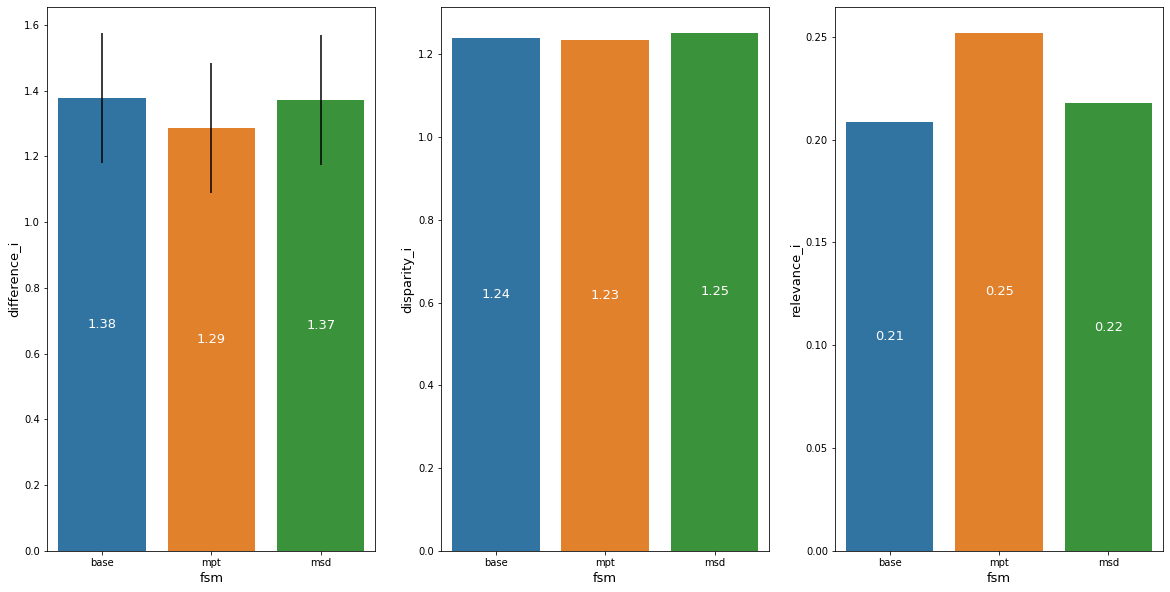

In [68]:
plot_levels_anova(anova, fsdata,'fsm','difference_i')

### EEL

#### ANOVA

In [69]:
formula = "difference_h ~ C(fsm) + C(qid)"
lm = ols(formula, fsdata).fit()
lm.summary()
anova = anova_lm(lm)

anova.round(2)

,df,sum_sq,mean_sq,F,PR(>F)
C(fsm),2.00000,0.21000,0.10000,0.36000,0.70000
C(qid),19.00000,16.27000,0.86000,2.99000,0.00000
Residual,38.00000,10.88000,0.29000,NaN,NaN


In [70]:
print_omegasq(anova,'fsm',20,2)
print_omegasq(anova,'qid',3,2)

omega-squared	omega-squared partial
-0.01			-0.07

omega-squared	omega-squared partial
0.4			0.93



#### Visualize

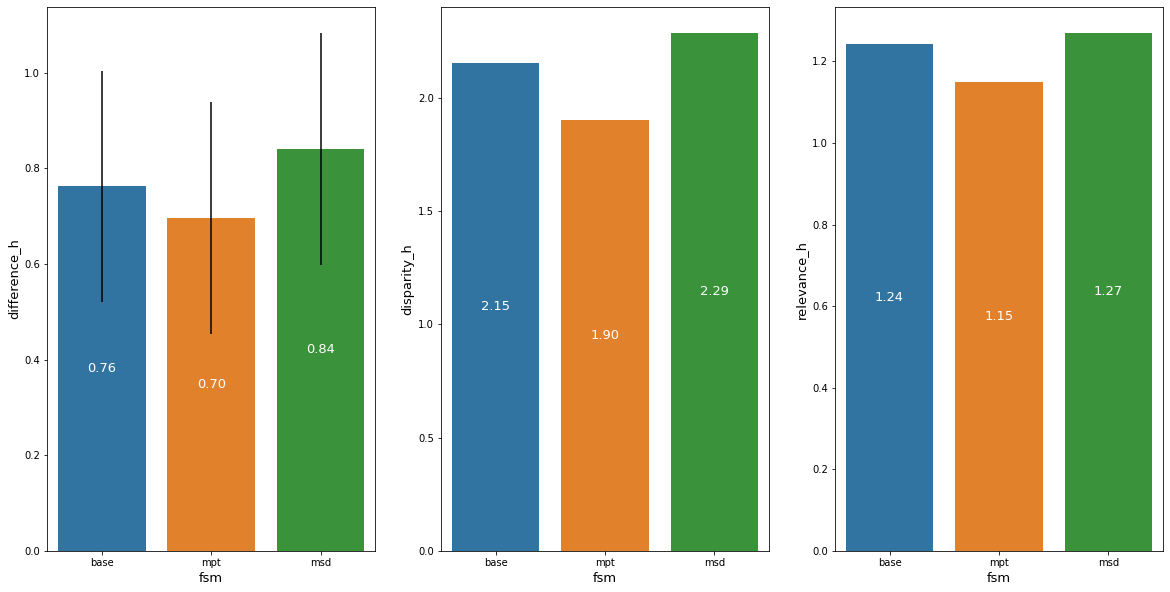

In [71]:
plot_levels_anova(anova, fsdata,'fsm','difference_h')

## LM with err optimization

In [97]:
errdata = experiments.query('ranker == "lambdamart" and source == "-" and augmentation == "-" and feature_method == "-"')
errdata = errdata.rename({'val_metric':'measure'},axis=1)
errdata.measure = errdata.measure.apply(lambda row: 'base' if row == 'ndcg' else row)
errdata

,difference_h,disparity_h,relevance_h,difference_i,disparity_i,relevance_i,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,measure,feature_method,num_features,balancing_factor,gr
57560,0.14245,1.82552,1.39822,1.74694,1.33307,0.01356,3462,lambdamart,-,-,-,-,-,-,err,-,-,-,-_-
57561,1.48436,3.00815,1.20748,1.39298,1.27083,0.33041,8940,lambdamart,-,-,-,-,-,-,err,-,-,-,-_-
57562,0.74300,2.03146,1.24893,1.67100,1.33309,0.00847,10795,lambdamart,-,-,-,-,-,-,err,-,-,-,-_-
57563,0.54990,1.97571,1.04348,1.39766,1.31667,0.04031,12073,lambdamart,-,-,-,-,-,-,err,-,-,-,-_-
57564,0.19235,2.77521,2.15771,2.07946,1.33332,0.01796,12096,lambdamart,-,-,-,-,-,-,err,-,-,-,-_-
57565,0.91768,2.38219,1.19640,2.04245,1.33327,0.03682,12828,lambdamart,-,-,-,-,-,-,err,-,-,-,-_-
57566,1.58034,1.40450,0.39899,1.39518,1.27082,0.22496,20363,lambdamart,-,-,-,-,-,-,err,-,-,-,-_-
57567,1.34969,3.00281,1.16200,1.35742,1.27059,0.17708,25869,lambdamart,-,-,-,-,-,-,err,-,-,-,-_-
57568,1.02184,3.12444,1.40341,1.42677,1.33321,0.00001,27887,lambdamart,-,-,-,-,-,-,err,-,-,-,-_-
57569,1.53580,3.05612,1.18478,2.08257,1.33333,0.01644,30631,lambdamart,-,-,-,-,-,-,err,-,-,-,-_-


In [98]:
with pd.option_context('precision', 3):
   print( errdata.groupby('measure').mean().round(3)[['difference_i','disparity_i','relevance_i','difference_h','disparity_h','relevance_h']].reset_index())

  measure  difference_i  disparity_i  relevance_i  difference_h  disparity_h  relevance_h
0    base       1.37800      1.23900      0.20800       0.76200      2.15400      1.24300
1     err       1.44000      1.25900      0.18700       0.90100      2.31300      1.25300


In [99]:
s1 = 'base'
s2 = 'err'

In [100]:
a = errdata.query(f'measure == "{s1}"').reset_index(drop=True)
b = errdata.query(f'measure == "{s2}"').reset_index(drop=True)

### ERR

#### t-test

In [89]:
stats.ttest_rel(a['difference_i'],b['difference_i'])

Ttest_relResult(statistic=-0.9213026936315917, pvalue=0.368443406665508)

In [91]:
differences = b['difference_i'] - a['difference_i']
sm = sample_mean(b['difference_i'],a['difference_i'])
sv = bigV(a['difference_i'],b['difference_i'])

In [92]:
c = ci(len(differences) - 1, sv, len(differences))
cl, ch = (sm - c, sm + c)
round(cl,2), round(ch,2)

(-0.08, 0.2)

In [93]:
sm

0.06186484999999999

In [94]:
sv

0.09018062530318684

In [101]:
effect_size_t_test(a['difference_i'],b['difference_i'],2)

0.21

#### Visualize

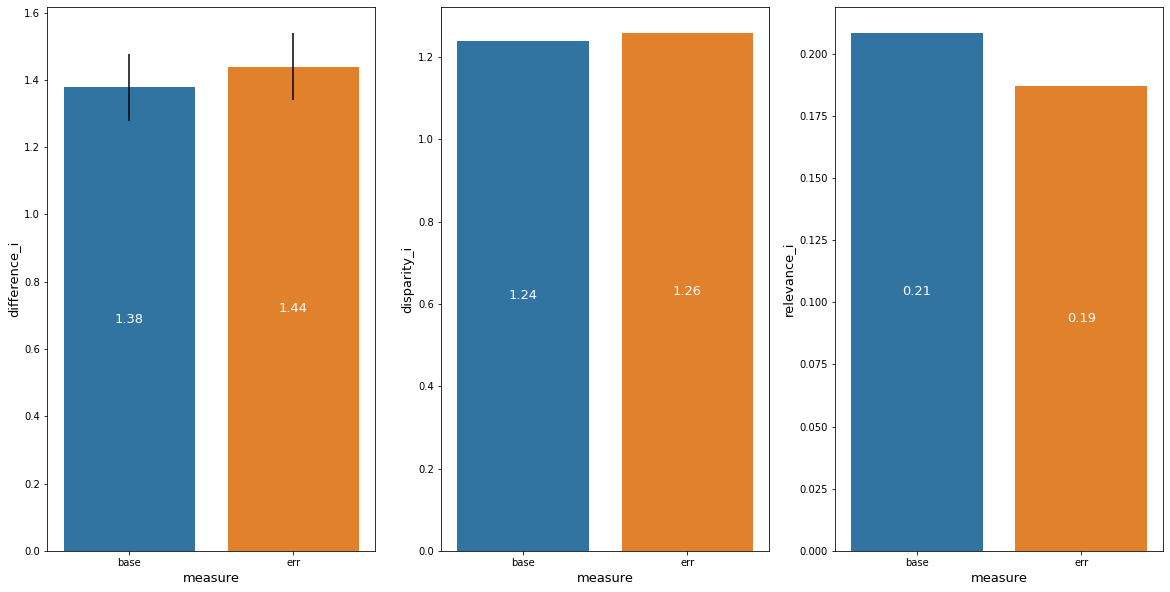

In [107]:
plot_levels_t(sv, 19, errdata, 'measure', 'difference_i')

### EEL

#### t-test

In [109]:
stats.ttest_rel(a['difference_h'],b['difference_h'])

Ttest_relResult(statistic=-1.5341166464868676, pvalue=0.14148480129860916)

In [110]:
differences = b['difference_h'] - a['difference_h']
sm = sample_mean(b['difference_h'],a['difference_h'])
sv = bigV(a['difference_h'],b['difference_h'])

In [111]:
c = ci(len(differences) - 1, sv, len(differences))
cl, ch = (sm - c, sm + c)
round(cl,2), round(ch,2)

(-0.05, 0.33)

In [112]:
sm

0.13922445

In [113]:
sv

0.1647192107181553

In [114]:
effect_size_t_test(a['difference_h'],b['difference_h'],2)

0.34

#### Visualize

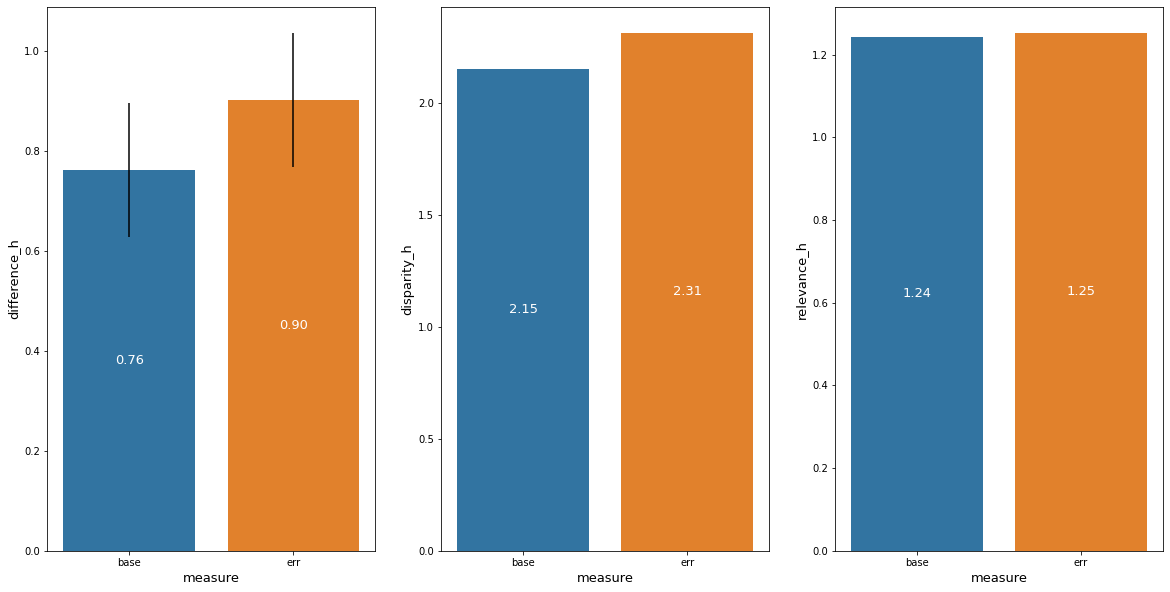

In [115]:
plot_levels_t(sv, 19, errdata, 'measure', 'difference_h')

## AC with group

In [121]:
acgroupdata = experiments.query('ranker == "ac" and source == "META_train" and theta == 9 and hfunc == "linear"')


acgroupdata.gr.value_counts()

author_ind     20
author_none    20
author_one     20
doc_-          20
Name: gr, dtype: int64

In [65]:
with pd.option_context('precision', 3):
   print( fsdata.drop(['source','theta','hfunc','group'],axis=1).groupby('fsm').mean().round(3)[['difference_i','disparity_i','relevance_i','difference_h','disparity_h','relevance_h']].reset_index())

    fsm  difference_i  disparity_i  relevance_i  difference_h  disparity_h  relevance_h
0  base       1.37800      1.23900      0.20800       0.76200      2.15400      1.24300
1   mpt       1.28600      1.23400      0.25200       0.69600      1.90200      1.14900
2   msd       1.37100      1.25100      0.21800       0.84000      2.28700      1.27000


### ERR

#### ANOVA

In [122]:
formula = "difference_i ~ C(gr) + C(qid)"
lm = ols(formula, acgroupdata).fit()
lm.summary()
anova = anova_lm(lm)
anova.round(2)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.07000,0.02000,7.53000,0.00000
C(qid),19.00000,3.76000,0.20000,66.30000,0.00000
Residual,57.00000,0.17000,0.00000,NaN,NaN


In [123]:
print_omegasq(anova,'gr',20,2)
print_omegasq(anova,'qid',3,2)

omega-squared	omega-squared partial
0.01			0.49

omega-squared	omega-squared partial
0.93			1.0



#### Visualize

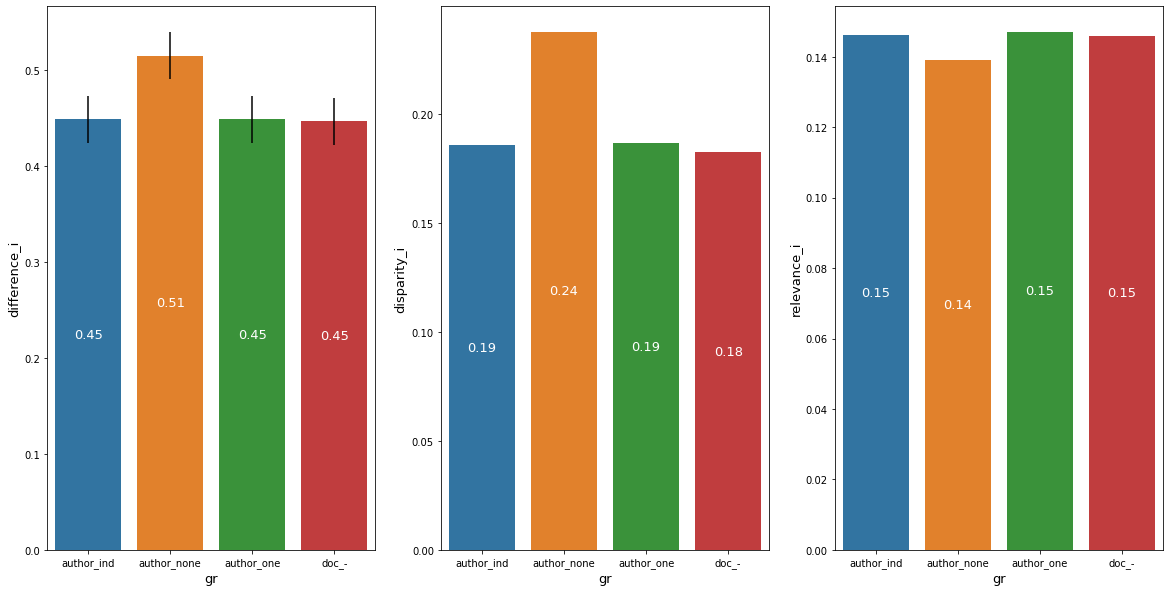

In [125]:
plot_levels_anova(anova, acgroupdata,'gr','difference_i')

#### Tukey

In [126]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acgroupdata['difference_i'], groups=acgroupdata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none    0.066 0.7952 -0.1229 0.2549  False
 author_ind  author_one  -0.0004    1.0 -0.1893 0.1885  False
 author_ind       doc_-  -0.0025    1.0 -0.1914 0.1864  False
author_none  author_one  -0.0665  0.792 -0.2553 0.1224  False
author_none       doc_-  -0.0685 0.7762 -0.2574 0.1204  False
 author_one       doc_-  -0.0021    1.0  -0.191 0.1868  False
-------------------------------------------------------------


### EEL

#### ANOVA

In [127]:
formula = "difference_h ~ C(gr) + C(qid)"
lm = ols(formula, acgroupdata).fit()
lm.summary()
anova = anova_lm(lm)

anova.round(2)

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.09000,0.03000,4.33000,0.01000
C(qid),19.00000,21.44000,1.13000,164.35000,0.00000
Residual,57.00000,0.39000,0.01000,NaN,NaN


In [70]:
print_omegasq(anova,'fsm',20,2)
print_omegasq(anova,'qid',3,2)

omega-squared	omega-squared partial
-0.01			-0.07

omega-squared	omega-squared partial
0.4			0.93



#### Visualize

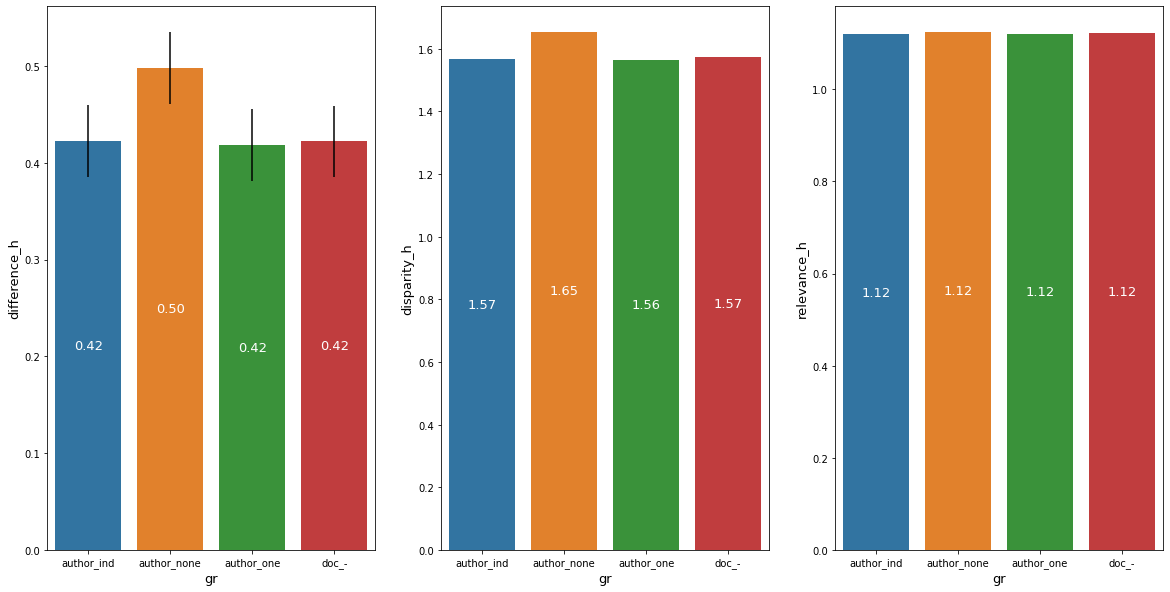

In [128]:
plot_levels_anova(anova, acgroupdata,'gr','difference_h')

#### Tukey

In [129]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acgroupdata['difference_h'], groups=acgroupdata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0753 0.9706 -0.3699 0.5204  False
 author_ind  author_one  -0.0045    1.0 -0.4497 0.4407  False
 author_ind       doc_-  -0.0006    1.0 -0.4457 0.4446  False
author_none  author_one  -0.0798 0.9653 -0.5249 0.3654  False
author_none       doc_-  -0.0758 0.9699  -0.521 0.3693  False
 author_one       doc_-   0.0039    1.0 -0.4412 0.4491  False
-------------------------------------------------------------


## AC with hfunc

In [131]:
acgroupdata = experiments.query('ranker == "ac" and source == "META_train" and theta == 9 and gr == "author_none"')


acgroupdata

,difference_h,disparity_h,relevance_h,difference_i,disparity_i,relevance_i,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
54980,0.08665,1.67281,1.34976,0.39971,0.10841,0.07484,3462,ac,META_train,author,none,9.00000,linear,-,-,-,-,-,author_none
54981,0.33297,1.35401,0.95611,0.56060,0.30670,0.26454,8940,ac,META_train,author,none,9.00000,linear,-,-,-,-,-,author_none
54982,0.13330,1.99526,1.53568,0.40325,0.17717,0.06439,10795,ac,META_train,author,none,9.00000,linear,-,-,-,-,-,author_none
54983,0.18885,1.14779,0.81005,0.20319,0.21369,0.08606,12073,ac,META_train,author,none,9.00000,linear,-,-,-,-,-,author_none
54984,0.27730,1.34047,1.39786,0.67783,0.18395,0.14410,12096,ac,META_train,author,none,9.00000,linear,-,-,-,-,-,author_none
54985,0.13396,1.51185,1.15309,0.80200,0.40405,0.19243,12828,ac,META_train,author,none,9.00000,linear,-,-,-,-,-,author_none
54986,0.76205,1.07346,0.64262,0.50541,0.22043,0.14465,20363,ac,META_train,author,none,9.00000,linear,-,-,-,-,-,author_none
54987,0.70400,2.26547,1.11618,0.36173,0.12028,0.09976,25869,ac,META_train,author,none,9.00000,linear,-,-,-,-,-,author_none
54988,0.09549,1.30195,0.95534,0.07123,0.05407,0.03821,27887,ac,META_train,author,none,9.00000,linear,-,-,-,-,-,author_none
54989,1.35031,1.63331,0.56612,1.05874,0.51477,0.11908,30631,ac,META_train,author,none,9.00000,linear,-,-,-,-,-,author_none


In [65]:
with pd.option_context('precision', 3):
   print( fsdata.drop(['source','theta','hfunc','group'],axis=1).groupby('fsm').mean().round(3)[['difference_i','disparity_i','relevance_i','difference_h','disparity_h','relevance_h']].reset_index())

    fsm  difference_i  disparity_i  relevance_i  difference_h  disparity_h  relevance_h
0  base       1.37800      1.23900      0.20800       0.76200      2.15400      1.24300
1   mpt       1.28600      1.23400      0.25200       0.69600      1.90200      1.14900
2   msd       1.37100      1.25100      0.21800       0.84000      2.28700      1.27000


### ERR

#### ANOVA

In [132]:
formula = "difference_i ~ C(hfunc) + C(qid)"
lm = ols(formula, acgroupdata).fit()
lm.summary()
anova = anova_lm(lm)
anova.round(2)

,df,sum_sq,mean_sq,F,PR(>F)
C(hfunc),2.00000,0.17000,0.08000,3.79000,0.03000
C(qid),19.00000,4.51000,0.24000,10.80000,0.00000
Residual,38.00000,0.84000,0.02000,NaN,NaN


In [123]:
print_omegasq(anova,'gr',20,2)
print_omegasq(anova,'qid',3,2)

omega-squared	omega-squared partial
0.01			0.49

omega-squared	omega-squared partial
0.93			1.0



#### Visualize

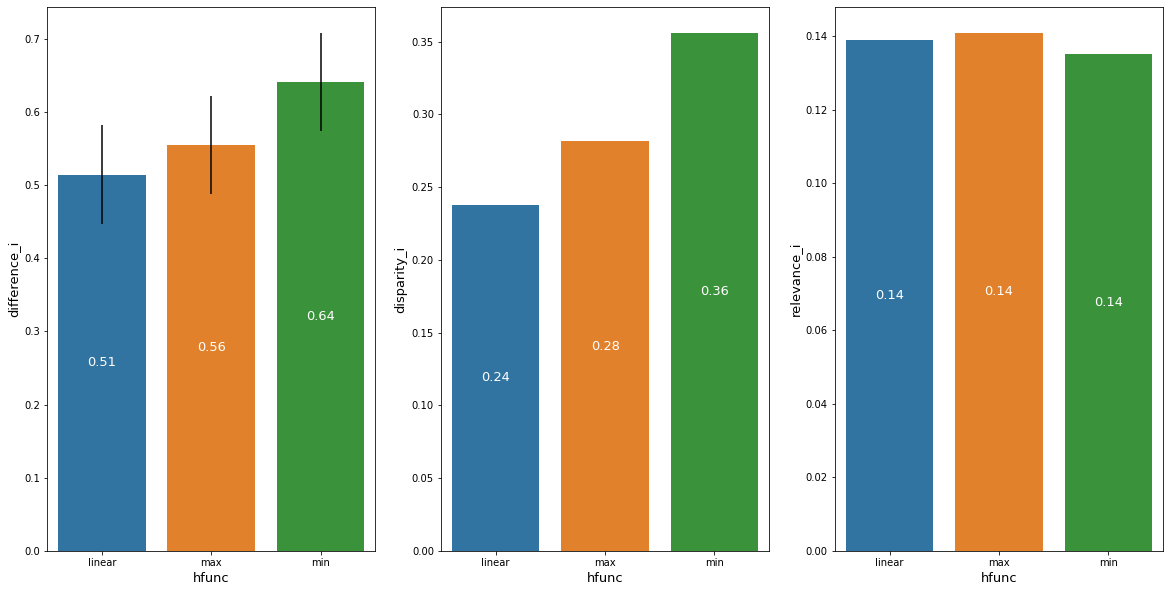

In [133]:
plot_levels_anova(anova, acgroupdata,'hfunc','difference_i')

#### Tukey

In [134]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acgroupdata['difference_i'], groups=acgroupdata['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
linear    max   0.0404 0.9087 -0.1927 0.2734  False
linear    min   0.1263 0.3986 -0.1067 0.3594  False
   max    min   0.0859 0.6504 -0.1471  0.319  False
---------------------------------------------------


### EEL

#### ANOVA

In [135]:
formula = "difference_h ~ C(hfunc) + C(qid)"
lm = ols(formula, acgroupdata).fit()
lm.summary()
anova = anova_lm(lm)

anova.round(2)

,df,sum_sq,mean_sq,F,PR(>F)
C(hfunc),2.00000,0.22000,0.11000,3.98000,0.03000
C(qid),19.00000,26.75000,1.41000,51.86000,0.00000
Residual,38.00000,1.03000,0.03000,NaN,NaN


In [70]:
print_omegasq(anova,'fsm',20,2)
print_omegasq(anova,'qid',3,2)

omega-squared	omega-squared partial
-0.01			-0.07

omega-squared	omega-squared partial
0.4			0.93



#### Visualize

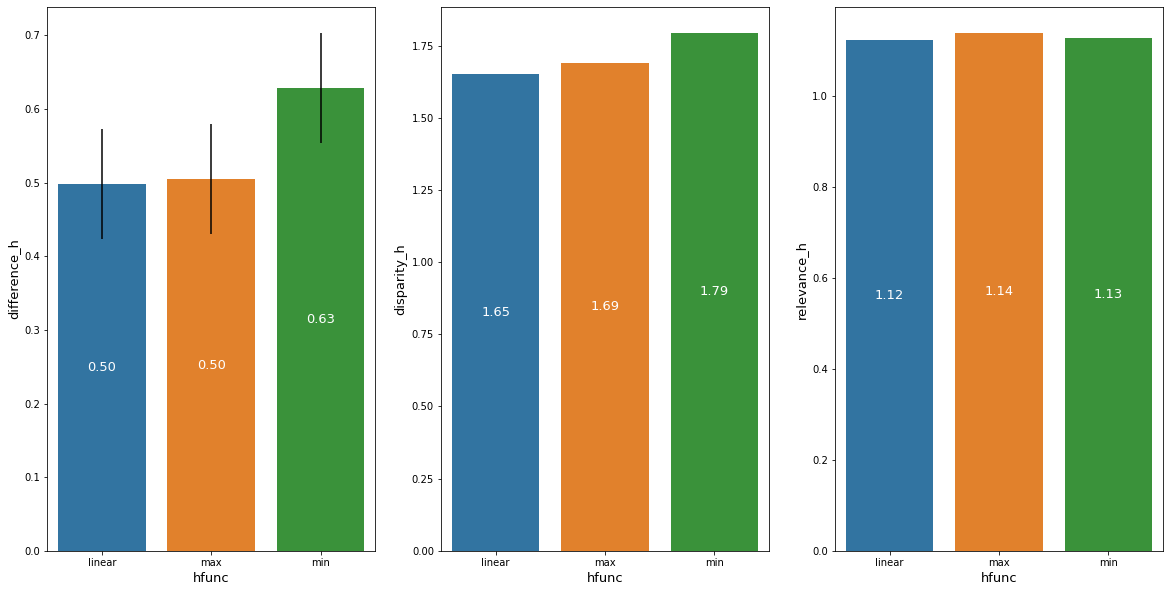

In [136]:
plot_levels_anova(anova, acgroupdata,'hfunc','difference_h')

#### Tukey

In [137]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acgroupdata['difference_h'], groups=acgroupdata['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
linear    max   0.0068 0.9995 -0.5245 0.5381  False
linear    min   0.1306 0.8252 -0.4007 0.6619  False
   max    min   0.1238 0.8413 -0.4075 0.6551  False
---------------------------------------------------
